In [1]:
!pip install python-dotenv -q

In [2]:
import os
import sys

# add parent folder to path to be able to import the modules
sys.path.append('..')

import azure.storage.blob as az_blob
from dotenv import load_dotenv
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests

from glance_utils.dictionaries import l2_class_dict, l1_class_dict, continent_dict

load_dotenv()

True

# The Boston University GLanCE dataset

Is a global land cover dataset, as described in [Stanimirova et al (2023): A global land cover training dataset from 1984 to 2020](https://www.nature.com/articles/s41597-023-02798-5). It contains point labels that are meant to capture land cover and land cover transitions through time. 

These can be used to train models to predict land cover from remotely sensed data. The key feature of this dataset is the information through time, which you can use in a clever way. 

For example, in Bolivia there's only about 90000 points, but for each point we have many satellite data observations. It's also highly imbalanced, where some classes have only a few hundred samples.

Below we take a look at the data and do some simple EDA to see what's up.

#### Make sure we have the necessary data and download if not.

In [4]:
# download the GLanCE dataset
glance_data_file = '../data/bu_glance_training_dataV1.parquet'
glance_link = 'https://data.source.coop/boston-university/bu-glance/bu_glance_training_dataV1.parquet'

if not os.path.exists(glance_data_file):
    response = requests.get(glance_link)
    with open(glance_data_file, 'wb') as f:
        f.write(response.content)

# Download the landsat scene identificators for Bolivia 
wrs_bolivia_path = '../data/landsat_wrs2_bolivia.gpkg'

# sort access to the AWS blob storage (you need to set up .env)
sas_token = os.environ['SAS_TOKEN']
container_client = az_blob.ContainerClient('https://lcchallenge.blob.core.windows.net', 
                                           "lc-challenge", credential=sas_token)

if not os.path.exists(wrs_bolivia_path):
    blob = container_client.download_blob('landsat_wrs2_bolivia.gpkg')
    with open(wrs_bolivia_path, 'wb') as wf:
        wf.write(blob.readall()) 

## Explore the data

In [5]:
gdf = gpd.read_parquet(glance_data_file)

# use the imported dictionaries to turn these into understandable labels.
gdf['Continent_Code'] = gdf['Continent_Code'].replace(continent_dict)
gdf['Glance_Class_ID_level1'] = gdf['Glance_Class_ID_level1'].replace(l1_class_dict)
gdf['Glance_Class_ID_level2'] = gdf['Glance_Class_ID_level2'].replace(l2_class_dict)

In [6]:
gdf.head(5)

,Lat,Lon,Start_Year,End_Year,Dataset_Code,Continent_Code,LC_Confidence,Segment_Type,Leaf_Type,Impervious_Percent,...,Tree_Location,Veg_Modifier,Level1_Ecoregion,Level2_Ecoregion,Glance_Class_ID_level1,Glance_Class_ID_level2,Change,ID,Glance_ID,geometry
0,1.414980,-71.083640,1985,2018,5,South America,NaN,NaN,NaN,NaN,...,NaN,None,7,7_00,Trees,NaN,False,0,02_7_00_5_0_1985_2018,POINT (-71.08364 1.41498)
1,1.972296,-70.944320,1985,2018,5,South America,NaN,NaN,NaN,NaN,...,NaN,None,7,7_00,Trees,NaN,False,1,02_7_00_5_1_1985_2018,POINT (-70.94432 1.97230)
2,2.097071,-73.839766,1985,2018,5,South America,NaN,NaN,NaN,NaN,...,NaN,None,7,7_00,Herbaceous,Grassland,False,2,02_7_00_5_2_1985_2018,POINT (-73.83977 2.09707)
3,1.205852,-71.773552,1986,2018,5,South America,NaN,NaN,NaN,NaN,...,NaN,None,7,7_00,Water,Water,False,3,02_7_00_5_3_1986_2018,POINT (-71.77355 1.20585)
4,1.205852,-71.775171,1986,2018,5,South America,NaN,NaN,NaN,NaN,...,NaN,None,7,7_00,Water,Water,False,4,02_7_00_5_4_1986_2018,POINT (-71.77517 1.20585)


you can see above that each sample has a latitude and longitude, start and end years (for which the observation is valid), some optional fields, and it has level 1 (and sometimes level2) land cover annotations. Let's look at these:

In [7]:
gdf['Glance_Class_ID_level1'].value_counts()

Glance_Class_ID_level1
Trees                        921563
Herbaceous                   655077
Water                        183160
Developed                     48185
Shrub                         37993
Barren/Sparsely vegetated     28937
Ice/Snow                         80
Name: count, dtype: int64

### Geographic distribution and label imbalance

let's clip it with our area in Bolivia and see what it looks like there:

In [8]:
# landsat scenes over our 10x10 degree box in Bolivia
bolivia_scenes = gpd.read_file(wrs_bolivia_path) 
gdf_bolivia = gdf.clip(bolivia_scenes)

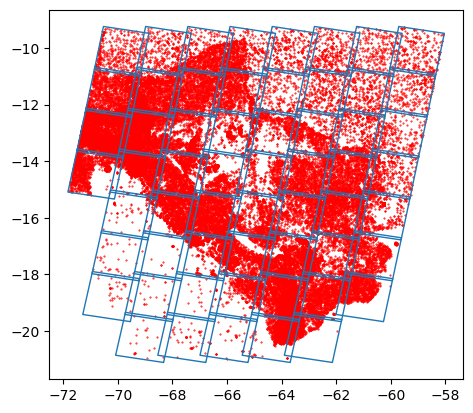

In [9]:
fig, ax = plt.subplots(1,1,)
gdf_bolivia.plot(color='red', ax=ax, markersize=0.2)

bolivia_scenes.boundary.plot(ax=ax, linewidth=1)
# wrs_bolivia[wrs_bolivia.PATH==228].plot(ax=ax, color='green')
plt.show()

In [10]:
len(gdf_bolivia)

96068

In [11]:
gdf_bolivia['Glance_Class_ID_level1'].value_counts()

Glance_Class_ID_level1
Trees                        54629
Herbaceous                   23020
Water                        17222
Shrub                          882
Barren/Sparsely vegetated      202
Developed                      113
Name: count, dtype: int64

So the data is spatially imbalanced, but also the labels are imbalanced too. Some of this will have to do with the actual imbalance in this country (there's much more Forest than developed land, for instance), but there will be some imbalance introduced by the sampling procedure.

### Change

The dataset also includes information on whether the labels have changed. However, as you can see below, only about 2% of them show change. However, [Global Forest Watch estimates that primary forest has decreased by about 9.1% between 2002 and 2022](https://www.globalforestwatch.org/dashboards/country/BOL/). 

Moreover the changes can be more than just forest change, suggesting that our dataset is underrepresenting change, which may be another challenge when trying to model and extract conclusions from the dataset. 

In [12]:
change_counts = gdf_bolivia['Change'].value_counts()

In [13]:
change_counts / change_counts.sum() * 100

Change
False    98.16276
True      1.83724
Name: count, dtype: float64